In [25]:
#Import Dependencies
%matplotlib inline
import os
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
from splinter import Browser
from splinter.exceptions import ElementDoesNotExist
import json
from pprint import pprint
from datetime import datetime
from datetime import timedelta 
import time
import matplotlib.pyplot as plt
import numpy as np

In [26]:
!which chromedriver

/usr/local/bin/chromedriver


In [27]:
#Variables
start_date = "2008-01-01"
initial_date = datetime(2008, 1, 1)
end_date = (datetime.today() - timedelta(days = 3)).date()
print(str(initial_date.date()))

2008-01-01


In [28]:
executable_path = {'executable_path': '/usr/local/bin/chromedriver'}
browser = Browser('chrome', **executable_path)

In [29]:
#Banxico URL
url = 'https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html'
browser.visit(url)
api_url = "https://www.banxico.org.mx/SieAPIRest/service/v1/series/"
banxico_key = "85c8edeab72128102cdad764f0a2d4532c336d22690a51104b500fb6f077ed4c"

In [30]:
html = browser.html
soup = bs(html, 'html.parser')

In [31]:
links = []
for link in soup.find_all('a'):
    if ('/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria') in link.get('href'):
        partial_link = link.get('href')
        links.append('http://www.banxico.org.mx' + partial_link)
links = links[1:]
#links

In [32]:
dates = []
for date in soup.find_all("td"):
    data = date.get_text()
    dates.append(data)
del dates[1::2]

In [33]:
import re
dates2 = []
for index in range(len(dates)):
    dates2.append(re.sub("\s", "", dates[index])) 


In [34]:
dates3 = []
for index in range(len(dates)):
    dates3.append(re.sub("[\/]", "", dates2[index])) 
#print(dates3)

In [35]:
name_counter = 0
for i in links:
    r = requests.get(i)
    out_file = open(f'{dates3[name_counter]}.pdf', 'wb')
    out_file.write(r.content)
    name_counter += 1

In [36]:
#Guillermo 
#pdf to text

In [37]:
final_dates = []
for date in dates2:
    dates = datetime.strptime(date, "%d/%m/%y")
    if dates > initial_date:
        final_dates.append(datetime.strftime(dates, "%Y-%m-%d"))
final_dates.append(datetime.strftime(end_date, "%Y-%m-%d"))

In [54]:
#MXN Lvl
Series = "SF43788"

fxt = []
for fecha in final_dates:
    url_consulta = [f"{api_url}{Series}/datos/{fecha}/{fecha}?token={banxico_key}"]
    for query in url_consulta: 
        data = requests.get(query).json()
        fxt.append(data["bmx"]["series"][0]["datos"][0]["dato"])
time.sleep(180) #tiempo del API

KeyError: 'bmx'

In [41]:
#Tasa Obejtivo
Series = "SF43878"

tasa = []
for fecha in final_dates:
    try:
        url_consulta = [f"{api_url}{Series}/datos/{fecha}/{fecha}?token={banxico_key}"]
        for query in url_consulta: 
            data = requests.get(query).json()
            tasa.append(data["bmx"]["series"][0]["datos"][0]["dato"])
    except:
        tasa.append(0)
time.sleep(180) #tiempo del API   

In [42]:
#Inflacion
Series = "SP30578"

#Total Data
total_query_url = f"{api_url}{Series}/datos/{start_date}/{end_date}?token={banxico_key}"
total_data = requests.get(total_query_url).json()
#print(total_data)
data_total = total_data['bmx']['series'][0]['datos']
data_total

[{'fecha': '01/01/2008', 'dato': '3.70000000'},
 {'fecha': '01/02/2008', 'dato': '3.72000000'},
 {'fecha': '01/03/2008', 'dato': '4.25000000'},
 {'fecha': '01/04/2008', 'dato': '4.55000000'},
 {'fecha': '01/05/2008', 'dato': '4.95000000'},
 {'fecha': '01/06/2008', 'dato': '5.26000000'},
 {'fecha': '01/07/2008', 'dato': '5.39000000'},
 {'fecha': '01/08/2008', 'dato': '5.57000000'},
 {'fecha': '01/09/2008', 'dato': '5.47000000'},
 {'fecha': '01/10/2008', 'dato': '5.78000000'},
 {'fecha': '01/11/2008', 'dato': '6.23000000'},
 {'fecha': '01/12/2008', 'dato': '6.53000000'},
 {'fecha': '01/01/2009', 'dato': '6.28000000'},
 {'fecha': '01/02/2009', 'dato': '6.20000000'},
 {'fecha': '01/03/2009', 'dato': '6.04000000'},
 {'fecha': '01/04/2009', 'dato': '6.17000000'},
 {'fecha': '01/05/2009', 'dato': '5.98000000'},
 {'fecha': '01/06/2009', 'dato': '5.74000000'},
 {'fecha': '01/07/2009', 'dato': '5.44000000'},
 {'fecha': '01/08/2009', 'dato': '5.08000000'},
 {'fecha': '01/09/2009', 'dato': '4.8900

In [43]:
#Match fechas
data_total_df = pd.DataFrame(data_total)
data_total_df['fecha'] = pd.to_datetime(data_total_df['fecha'], format='%d/%m/%Y')
data_total_df['key'] = pd.to_datetime(data_total_df['fecha']).dt.to_period('M')
data_total_df

,fecha,dato,key
0,2008-01-01,3.70000000,2008-01
1,2008-02-01,3.72000000,2008-02
2,2008-03-01,4.25000000,2008-03
3,2008-04-01,4.55000000,2008-04
4,2008-05-01,4.95000000,2008-05
...,...,...,...
144,2020-01-01,3.24000000,2020-01
145,2020-02-01,3.70000000,2020-02
146,2020-03-01,3.25000000,2020-03
147,2020-04-01,2.15000000,2020-04


In [44]:
pre_banxico_dict = {"MXN": fxt,  "Tasa": tasa}
pre_banxico_df = pd.DataFrame(pre_banxico_dict)
pre_banxico_df['Fecha'] = final_dates
pre_banxico_df['key'] = pd.to_datetime(pre_banxico_df['Fecha']).dt.to_period('M')
pre_banxico_df = pre_banxico_df.sort_values('Fecha')
pre_banxico_df = pre_banxico_df[pre_banxico_df.Tasa != 0]
pre_banxico_df = pre_banxico_df.reset_index(drop = True)
pre_banxico_df

,MXN,Tasa,Fecha,key
0,0,8.6600,2008-08-15,2008-08
1,0,8.7500,2008-09-19,2008-09
2,0,8.7350,2008-10-17,2008-10
3,0,8.8500,2008-11-28,2008-11
4,0,8.5650,2009-01-16,2009-01
...,...,...,...,...
98,0,7.5575,2019-12-19,2019-12
99,0,7.3550,2020-02-13,2020-02
100,0,7.0425,2020-03-20,2020-03
101,0,6.5015,2020-04-21,2020-04


In [45]:
banxico_merge = data_total_df.merge(pre_banxico_df, on='key')
banxico_merge['Tasa'] = banxico_merge['Tasa'].astype(float)
banxico_merge['Dif'] = 0
banxico_merge.tail()


,fecha,dato,key,MXN,Tasa,Fecha,Dif
98,2019-12-01,2.83000000,2019-12,0,7.5575,2019-12-19,0
99,2020-02-01,3.70000000,2020-02,0,7.3550,2020-02-13,0
100,2020-03-01,3.25000000,2020-03,0,7.0425,2020-03-20,0
101,2020-04-01,2.15000000,2020-04,0,6.5015,2020-04-21,0
102,2020-05-01,2.84000000,2020-05,0,6.0763,2020-05-14,0


In [46]:
#Fix Array
banxico_merge.rename(columns = {'dato':'Inflacion'}, inplace = True) 
banxico_merge = banxico_merge.reset_index(drop = True)
banxico_merge = banxico_merge.drop(['fecha', 'key'], axis = 1) 
banxico_merge['Tasa'] = banxico_merge['Tasa'].astype(float)
banxico_merge = banxico_merge[['Fecha', 'MXN', 'Inflacion', 'Tasa', 'Dif']]
banxico_merge

,Fecha,MXN,Inflacion,Tasa,Dif
0,2008-08-15,0,5.57000000,8.6600,0
1,2008-09-19,0,5.47000000,8.7500,0
2,2008-10-17,0,5.78000000,8.7350,0
3,2008-11-28,0,6.23000000,8.8500,0
4,2009-01-16,0,6.28000000,8.5650,0
...,...,...,...,...,...
98,2019-12-19,0,2.83000000,7.5575,0
99,2020-02-13,0,3.70000000,7.3550,0
100,2020-03-20,0,3.25000000,7.0425,0
101,2020-04-21,0,2.15000000,6.5015,0


In [47]:
for i in range(1, len(banxico_merge) -1 ):
    banxico_merge.loc[i, 'Dif'] = 25 * round((100 * (banxico_merge.loc[i, 'Tasa'] - banxico_merge.loc[i-1, 'Tasa']))/25)

In [48]:
banxico_merge['key'] = pd.to_datetime(banxico_merge['Fecha']).dt.to_period('M')
banxico_merge

,Fecha,MXN,Inflacion,Tasa,Dif,key
0,2008-08-15,0,5.57000000,8.6600,0.0,2008-08
1,2008-09-19,0,5.47000000,8.7500,0.0,2008-09
2,2008-10-17,0,5.78000000,8.7350,-0.0,2008-10
3,2008-11-28,0,6.23000000,8.8500,0.0,2008-11
4,2009-01-16,0,6.28000000,8.5650,-25.0,2009-01
...,...,...,...,...,...,...
98,2019-12-19,0,2.83000000,7.5575,-25.0,2019-12
99,2020-02-13,0,3.70000000,7.3550,-25.0,2020-02
100,2020-03-20,0,3.25000000,7.0425,-25.0,2020-03
101,2020-04-21,0,2.15000000,6.5015,-50.0,2020-04


In [49]:
#import frecuencias_banxico.csv
frecuencias_df = pd.read_csv('frecuencias_banxico.csv')
frecuencias_df.rename(columns={'Unnamed: 0':'name'}, inplace=True)
frecuencias_df['key'] = frecuencias_df['name'].str.replace('count',"")
frecuencias_df['key'] = pd.to_datetime(frecuencias_df['key'].astype(str), format='%d%m%y')
frecuencias_df['key'] = pd.to_datetime(frecuencias_df['key']).dt.to_period('M')
frecuencias_df

,name,apreciacion,crecimiento,holgura,inflacion,mantener,moneda,volatilidad,depreciacion,deterioro,lasitud,disminuir,estable,aumentar,index,key
0,020818count,2.0,2.0,3.0,13.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,2018-08
1,021211count,0.0,6.0,1.0,11.0,2.0,1.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,-8.0,2011-12
2,040216count,2.0,10.0,2.0,16.0,3.0,3.0,2.0,5.0,3.0,0.0,0.0,0.0,0.0,-15.0,2016-02
3,040311count,0.0,3.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,2011-03
4,040615count,1.0,3.0,3.0,16.0,2.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,-18.0,2015-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,300616count,0.0,8.0,1.0,14.0,1.0,4.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,-16.0,2016-06
106,300715count,2.0,2.0,3.0,17.0,4.0,2.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,-21.0,2015-07
107,301112count,1.0,6.0,0.0,12.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,2012-11
108,310114count,0.0,5.0,3.0,17.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.0,2014-01


In [50]:
banxico_merge = banxico_merge.merge(frecuencias_df, on='key')
banxico_merge = banxico_merge.drop(['name', 'key'], axis = 1)
banxico_merge

,Fecha,MXN,Inflacion,Tasa,Dif,apreciacion,crecimiento,holgura,inflacion,mantener,moneda,volatilidad,depreciacion,deterioro,lasitud,disminuir,estable,aumentar,index
0,2008-08-15,0,5.57000000,8.6600,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-3.0
1,2008-09-19,0,5.47000000,8.7500,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2008-10-17,0,5.78000000,8.7350,-0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,-5.0
3,2008-11-28,0,6.23000000,8.8500,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,-5.0
4,2009-01-16,0,6.28000000,8.5650,-25.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2019-12-19,0,2.83000000,7.5575,-25.0,0.0,4.0,6.0,13.0,0.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,-3.0
101,2020-02-13,0,3.70000000,7.3550,-25.0,1.0,1.0,2.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,-1.0
102,2020-03-20,0,3.25000000,7.0425,-25.0,0.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,-4.0
103,2020-04-21,0,2.15000000,6.5015,-50.0,0.0,1.0,1.0,4.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,-4.0


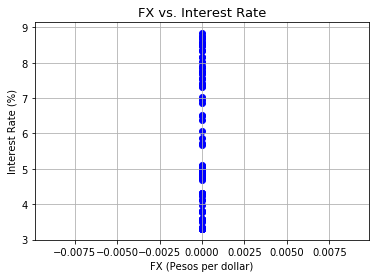

In [55]:
title = f"FX vs. Interest Rate"
plt.scatter(banxico_merge["MXN"], banxico_merge["Tasa"], marker = "o", color="blue")
plt.title(title, size=13)
plt.xlabel("FX (Pesos per dollar)")
plt.ylabel("Interest Rate (%)")
plt.grid(True)
plt.savefig(f"{title}.png")

In [57]:
from scipy.stats import linregress
title = "Inflation counts vs. FX Regression"
x = banxico_merge["inflacion"]
y = banxico_merge["MXN"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x,y)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq,(17,18.8),fontsize=15,color="red")
plt.title(title)
plt.xlabel('Inflation counts')
plt.ylabel("FX (pesos per dollar)")
plt.savefig(f"{title}.png")
print(f"The r-squared is: {rvalue}")
plt.show()

The r-squared is: 0.0


ValueError: Image size of 418x134842 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

The r-squared is: 0.05501743232499773


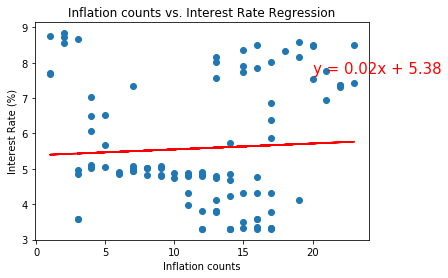

In [58]:
#Aqui va como x "inflacion" (la del conteo, no la de los números) y la tasa de interés (no el diferencial)
title = "Inflation counts vs. Interest Rate Regression"
x = banxico_merge["inflacion"]
y = banxico_merge["Tasa"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x,y)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq,(20,7.7),fontsize=15,color="red")
plt.title(title)
plt.xlabel('Inflation counts')
plt.ylabel("Interest Rate (%)")
plt.savefig(f"{title}.png")
print(f"The r-squared is: {rvalue}")
plt.show()

The r-squared is: -0.1311694588466093


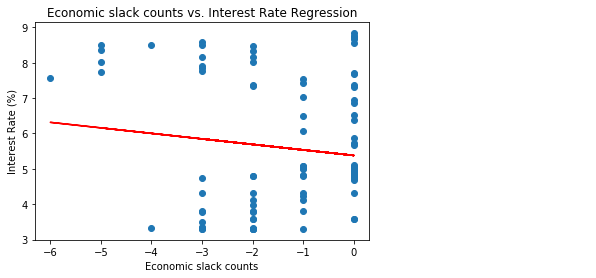

In [59]:
title = "Economic slack counts vs. Interest Rate Regression"
x = banxico_merge["holgura"]*-1
y = banxico_merge["Tasa"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x,y)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq,(2,7.7),fontsize=15,color="red")
plt.title(title)
plt.xlabel('Economic slack counts')
plt.ylabel("Interest Rate (%)")
plt.savefig(f"{title}.png")
print(f"The r-squared is: {rvalue}")
plt.show()

The r-squared is: -0.08678430115381534


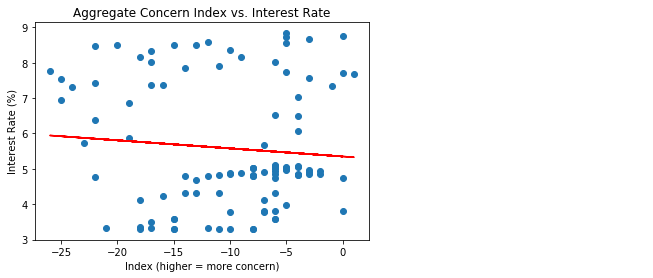

In [60]:
title = "Aggregate Concern Index vs. Interest Rate"
x = banxico_merge["index"]
y = banxico_merge["Tasa"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x,y)
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq,(15,7.7),fontsize=15,color="red")
plt.title(title)
plt.xlabel('Index (higher = more concern)')
plt.ylabel("Interest Rate (%)")
plt.savefig(f"{title}.png")
print(f"The r-squared is: {rvalue}")
plt.show()

In [ ]:
#Identify data anomalities
banxico_merge.describe()

In [ ]:
#One Hot Encoding
#banxico_clean = pd.get_dummies(banxico_merge)
#banxico_clean.tail(30)

In [ ]:
#Assign target and variables
target = np.array(banxico_merge['Dif'])
variables = banxico_merge.drop(["Dif", "Fecha"], axis = 1)
variable_list = list(variables.columns)
variables = np.array(variables)

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_variables, test_variables, train_target, test_target = train_test_split(variables, target, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Variables Shape:', train_variables.shape)
print('Training TArget Shape:', train_target.shape)
print('Testing Variables Shape:', test_variables.shape)
print('Testing TArget Shape:', test_target.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
classifier  = RandomForestRegressor(n_estimators = 1000, random_state = 42)
classifier.fit(train_variables, train_target);
classifier.fit(variables, target)

In [ ]:
# Use the forest's predict method on the test data
predictions = classifier .predict(test_variables)
# Calculate the absolute errors
errors = abs(predictions - test_target)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Basicos.')


In [ ]:
# Get VAriable importances
importances = list(classifier .feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(variable_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, variable_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
predictions = classifier.predict(variables)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {test_target[:10].tolist()}")